In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/My\ Drive/repositories/covid19_synthesis/

/content/drive/My Drive/repositories/covid19_synthesis


In [ ]:
from nbdev_c19_synthesis.c19_synthesis.core import *
from nbdev_c19_synthesis.c19_synthesis.cellular_automata import *

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import label
from scipy.ndimage import binary_erosion, binary_dilation, binary_fill_holes
from scipy import ndimage
import os

In [ ]:
from sklearn.cluster import DBSCAN
from copy import copy
from scipy.ndimage import binary_closing
from scipy.ndimage import distance_transform_bf

In [ ]:
import torch
import torch.nn.functional as F
from time import time
from IPython.display import Image, HTML, clear_output

In [ ]:
import imageio
import os
import moviepy.editor as mvp
from pathlib import Path
from tqdm.notebook import tqdm
from skimage.restoration import inpaint

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)1941504/45929032 bytes (4.2%)4268032/45929032 bytes (9.3%)6873088/45929032 bytes (15.0%)9322496/45929032 bytes (20.3%)11706368/45929032 bytes (25.5%)14376960/45929032 bytes (31.3%)16990208/45929032 bytes (37.0%)19759104/45929032 bytes (43.0%)22192128/45929032 bytes (48.3%)24772608/45929032 bytes (53.9%)27377664/45929032 bytes (59.6%)29999104/45929032 bytes (65.3%)324

In [ ]:
%load_ext autoreload
%autoreload 2

# Project name here

> Summary description here.

This file will become your README and also the index of your documentation.

## Install

`pip install your_project_name`

## get lungs and cluster lesions

Fill me in please! Don't forget code examples:

In [ ]:
# read files
filename = 'covid19-A-0003_ct.nii.gz'
path_source = '/content/drive/My Drive/Datasets/covid19/COVID-19-20_v2/'
path_dest = '/content/drive/My Drive/KCL/covid19/inpainting_results/'
# load ct, normalize, rotate, 
ct, ct_mask, ct_seg = read_covid_CT_and_mask(path_source, filename)
ct, ct_mask, ct_seg = normalize_rotate(ct, ct_mask, ct_seg)
ct_small, ct_mask_small, ct_seg_small = ct, ct_mask, ct_seg
labelled, nr = label(ct_seg_small>0)
largest_component = (labelled == (np.bincount(labelled.flat)[1:].argmax() + 1))
# find the two lungs
ERODE_ITER = 5
ct_seg_erod = binary_erosion(ct_seg_small>0, iterations=ERODE_ITER)
lab, nr = label(ct_seg_erod)
lab_areas = np.array(ndimage.sum(ct_seg_erod, lab, np.arange(lab.max()+1)))
mask_small_lab_areas = lab_areas > 500000
two_lungs = mask_small_lab_areas[lab.ravel()].reshape(lab.shape)
two_lungs, nr = label(two_lungs)
assert nr == 2
# masks
bkgd = ct_seg_small == 0
target_mask = np.logical_or(bkgd,ct_mask_small)
target_mask = ~target_mask #lungs without lesions
target_mask2 = ~bkgd # lungs with lesions
target_mask3 = ct_mask_small.astype(bool) #lesions only
SLICE=100
# get largest lesion using label
lab, nr_ = label(target_mask3)
lab_areas = np.array(ndimage.sum(target_mask3, lab, np.arange(lab.max()+1)))
mask_small_lab_areas = lab_areas > 5000
one_big_lesion = mask_small_lab_areas[lab.ravel()].reshape(lab.shape)
lab, nr_ = label(one_big_lesion)
# get dimensions of one_big_lesion and find one_big_lesion is in left or right lung 
y_min_lesion, y_max_lesion, x_min_lesion, x_max_lesion, z_min_lesion, z_max_lesion = get_min_max(one_big_lesion)
for i in [1,2]:
  y_min, y_max, x_min, x_max, z_min, z_max = get_min_max(two_lungs, LABEL=i)
  if y_min_lesion >= y_min and y_max_lesion <= y_max and x_min_lesion >= x_min and x_max_lesion <= x_max and z_min_lesion >= z_min and z_max_lesion <= z_max:
    coords_lung_inpaint = y_min, y_max, x_min, x_max, z_min, z_max
lung_inpaint = ct_seg_small[coords_lung_inpaint[0]:coords_lung_inpaint[1],coords_lung_inpaint[2]:coords_lung_inpaint[3],coords_lung_inpaint[4]:coords_lung_inpaint[5]]
lung_one_big_lesion = one_big_lesion[coords_lung_inpaint[0]:coords_lung_inpaint[1],coords_lung_inpaint[2]:coords_lung_inpaint[3],coords_lung_inpaint[4]:coords_lung_inpaint[5]]
# pad each dimension to length multiple of 32 (needed for inpainting, maye not anymore)
mask_inpain = ~(lung_one_big_lesion + (lung_inpaint==0))
img = pad_two_size_multiple_32(lung_inpaint)
mask_inpain = pad_two_size_multiple_32(mask_inpain)
lung_one_lesion = pad_two_size_multiple_32(lung_inpaint, lung_one_big_lesion)
# get the lung with the lesion
target_img_covid = img * lung_one_lesion
y_min, y_max, x_min, x_max, z_min, z_max =  get_min_max(lung_one_lesion)
target_img_covid = target_img_covid[y_min: y_max, x_min: x_max, z_min: z_max]
SLICE = 50
im = copy(target_img_covid[...,SLICE])

(198, 144)

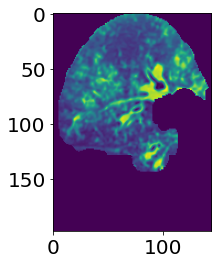

In [ ]:
plt.imshow(im)
np.shape(im)

(198, 144, 101)


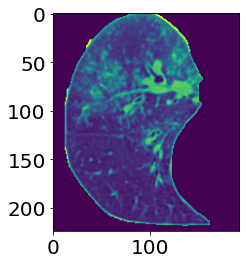

In [ ]:
# get the lungs only
mask_lungs_32 = pad_two_size_multiple_32(target_mask2[coords_lung_inpaint[0]:coords_lung_inpaint[1],coords_lung_inpaint[2]:coords_lung_inpaint[3],coords_lung_inpaint[4]:coords_lung_inpaint[5]])
mask_lungs_32 = mask_lungs_32[y_min: y_max, x_min: x_max, z_min: z_max]
print(np.shape(mask_lungs_32))
plt.imshow(img[...,SLICE+z_min])

In [ ]:
# path_synthesis = '/content/drive/My Drive/Datasets/covid19/results/cea_synthesis/patient05_superpix_sigma=.2_compact=.1/'
# path_synthesis = '/content/drive/My Drive/Datasets/covid19/results/cea_synthesis/patient06_grow=3_bg=0.19_step=1/'
# path_synthesis = '/content/drive/My Drive/Datasets/covid19/results/cea_synthesis/patient06_grow=3_bg=0.19_step=0.3/'
# path_synthesis = '/content/drive/My Drive/Datasets/covid19/results/cea_synthesis/patient06_grow=6_bg=0.19_step=0.3/'
path_synthesis = '/content/drive/My Drive/Datasets/covid19/results/cea_synthesis/patient06_grow=1_bg=0.19_step=0.3/'
path_synthesis = '/content/drive/My Drive/Datasets/covid19/results/cea_synthesis/patient06_grow=1_bg=0.19_step=1_scale_mask=0.19/'
# path_synthesis = '/content/drive/My Drive/Datasets/covid19/results/cea_synthesis/patient06_grow=1_bg=0.19_step=1_scale_mask=1/'
# path_synthesis = '/content/drive/My Drive/Datasets/covid19/results/cea_synthesis/patient06_grow=1_bg=0.19_step=0.1_scale_mask=0.1/'
path_synthesis = '/content/drive/My Drive/Datasets/covid19/results/cea_synthesis/patient06_grow=1_bg=0.19_step=0.1_scale_mask=10/'
path_synthesis = '/content/drive/My Drive/Datasets/covid19/results/cea_synthesis/patient06_grow=1_bg=1.00_step=0.1_scale_mask=1/'
path_synthesis = '/content/drive/My Drive/Datasets/covid19/results/cea_synthesis/patient06_grow=1_bg=0.11_step=0.1_scale_mask=1/'
path_synthesis = '/content/drive/My Drive/Datasets/covid19/results/cea_synthesis/patient06_grow=1_bg=0.01_step=0.1_scale_mask=1/'
path_synthesis = '/content/drive/My Drive/Datasets/covid19/results/cea_synthesis/patient06_grow=1_bg=0.01_step=0.1_scale_mask=1_seed_value=0.19/'



all_files = os.listdir(path_synthesis)
lesion_files = [i for i in all_files if i.startswith('lesion')]

coords_files = [i for i in all_files if i.startswith('coords_lesion')]
masks_files = [i for i in all_files if i.startswith('mask_lesion')]
# read lesions and coordinates making sure both files exist
lesions_all = []
coords_all = []
masks_all = []
lesion_nr = []
losses_all = []
possible_lesions = np.arange(np.max((len(lesion_files), len(coords_files),len(masks_files))))
for i in possible_lesions:
  if f'lesion_{i}.npz' in lesion_files and f'coords_lesion_{i}.npy' in coords_files and f'mask_lesion_{i}.npz' in masks_files:
    lesion_ = np.load(f'{path_synthesis}lesion_{i}.npz')
    lesions_all.append(lesion_.f.arr_0)
    coords_all.append(np.load(f'{path_synthesis}coords_lesion_{i}.npy'))
    mask_ = np.load(f'{path_synthesis}mask_lesion_{i}.npz')
    masks_all.append(mask_.f.arr_0)
    loss = np.load(f'{path_synthesis}loss_lesion_{i}.npy')
    losses_all.append(loss)
    lesion_nr.extend([i])
print(len(lesions_all), len(coords_all), len(masks_all))
# lesion_nr

21 21 21


In [ ]:
path_synthesis_old = '/content/drive/My Drive/Datasets/covid19/results/cea_synthesis/patient0/'
texture_orig = np.load(f'{path_synthesis_old}texture.npy.npz')
texture_orig = texture_orig.f.arr_0
texture = texture_orig + np.abs(np.min(texture_orig)) + .07

-0.48188075 0.07


(0.0, 1.0)

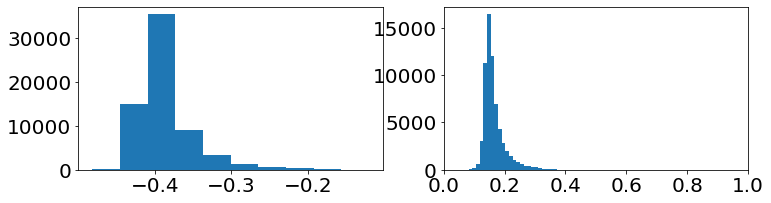

In [ ]:
print(np.min(texture_orig), np.min(texture))
fig, ax = plt.subplots(1,2,figsize=(12,3))
ax[0].hist(texture_orig.flatten());
# ax[0].set_xlim([0,1])
ax[1].hist(texture.flatten(), bins=30);
ax[1].set_xlim([0,1])

## blend test

(0.0, 1.0)

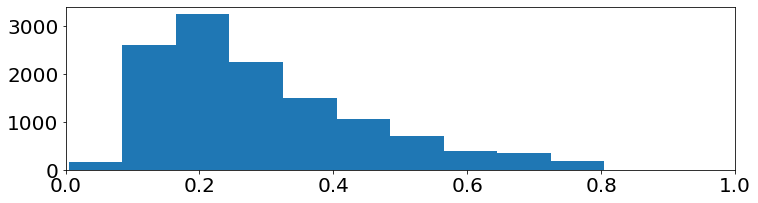

In [ ]:
plt.figure(figsize=(12,3))
plt.hist(target_img_covid[target_img_covid[...,SLICE]>0,SLICE]);
plt.xlim([0,1])

(22, 35) (22, 35)


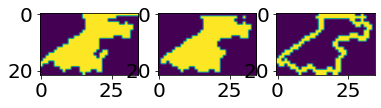

In [ ]:
GEN = 10
iter_erosion_dilation = 1
for idx_, (lesion, coord, mask) in enumerate(zip(lesions_all, coords_all, masks_all)):
  if idx_ == 0:continue
  syn_norm = lesion[GEN]/255. # WARNING this might not be the best way to save the array (information lost)
  syn_norm = syn_norm * mask
  mask_closed = binary_closing(mask)
  mask_in = (mask_closed).astype('int') - binary_erosion(mask_closed, iterations=iter_erosion_dilation)
  mask_out = binary_dilation(mask_closed, iterations=iter_erosion_dilation) - (mask_closed).astype('int')
  mask_ring = mask_in + mask_out
  break
print(np.shape(mask),np.shape(mask_ring))
fig, ax = plt.subplots(1,3)
ax[0].imshow(mask)
ax[1].imshow(mask_closed)
ax[2].imshow(mask_ring)

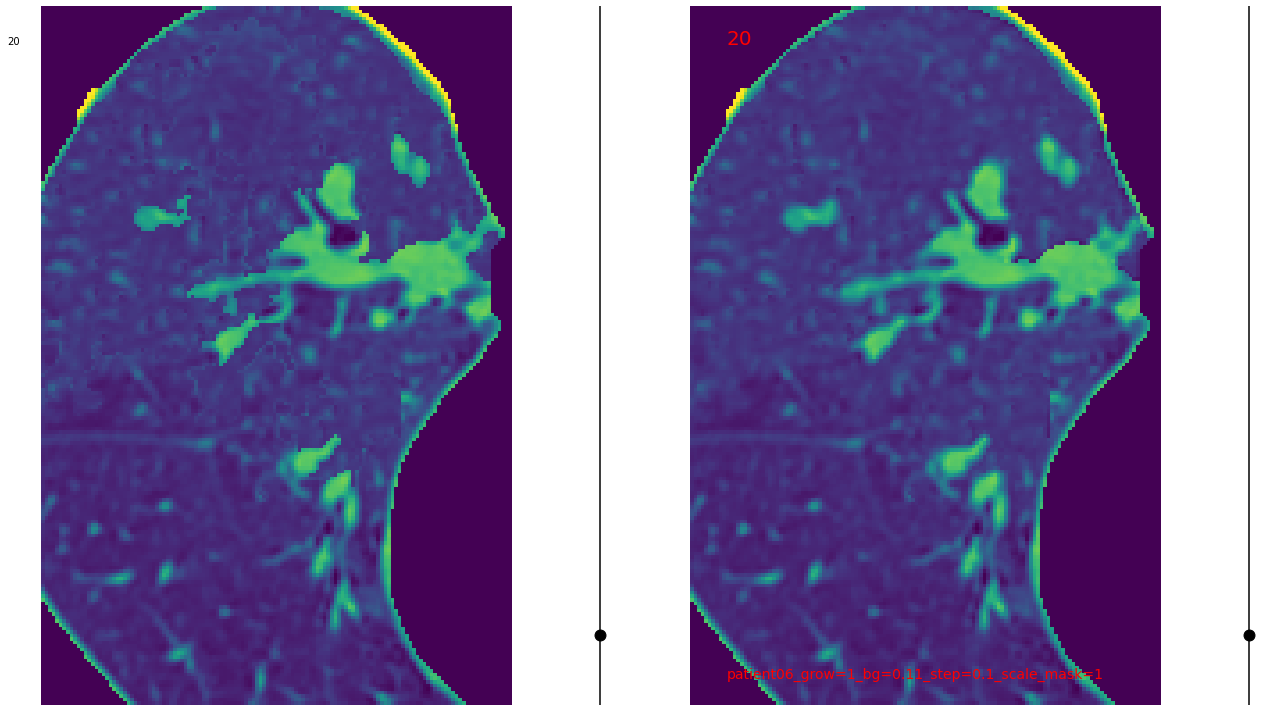

In [ ]:
##@title Put the background texture with and without inpainted borders {vertical-output: true}
im_blend = copy(target_img_covid[...,SLICE])
mask_covid = target_img_covid[...,SLICE]>0
name_synthesis = path_synthesis.split('/')[-2]
not_covid = img[y_min: y_max, x_min: x_max, SLICE+z_min] * (~mask_covid).astype(float)
V_MAX = np.max(img[y_min: y_max, x_min: x_max, SLICE+z_min])
mask_for_inpain = np.zeros_like(im_blend)
for lesion, coord, mask in zip(lesions_all, coords_all, masks_all):
  new_coords_mask = np.where(mask==1)[0]+coord[0], np.where(mask==1)[1]+coord[2] # add background texture with absolute coordinates
  im_blend[new_coords_mask] = texture[new_coords_mask] 
  # rings
  mask_closed = binary_fill_holes(mask,)
  mask_in = (mask_closed).astype('int') - binary_erosion(mask_closed, iterations=iter_erosion_dilation)
  mask_out = binary_dilation(mask_closed, iterations=iter_erosion_dilation) - (mask_closed).astype('int')
  mask_ring = mask_in + mask_out

  new_coords_mask_inpain = np.where(mask_ring==1)[0]+coord[0], np.where(mask_ring==1)[1]+coord[2] # mask outer rings for inpaint
  mask_for_inpain[new_coords_mask_inpain] = 1 
im_blend_inpain = inpaint.inpaint_biharmonic(im_blend, mask_for_inpain)


im_blend_inpain = im_blend_inpain * mask_covid + not_covid
im_blend = im_blend * mask_covid + not_covid
fig, ax = plt.subplots(1,4, gridspec_kw={'width_ratios': [30, 1,30,1]}, figsize=(18,10))
ax[0].imshow(im_blend[y_min: y_max, x_min: x_max], cmap='viridis', vmin=0, vmax=V_MAX)
ax[0].text(-10,10, i)
ax[1].vlines(x=0, ymin=0, ymax=len(lesion), color='k')
ax[1].scatter(0,GEN, c='k', s=120)
ax[1].set_ylim([0,100])
ax[2].imshow(im_blend_inpain[y_min: y_max, x_min: x_max], cmap='viridis')
ax[2].text(10,10, i, fontsize=20, c='r')
ax[2].text(10,np.shape(mask_for_inpain)[0]-10, name_synthesis, fontsize=14, c='r')
ax[3].vlines(x=0, ymin=0, ymax=len(lesion), color='k')
ax[3].scatter(0,GEN, c='k', s=120)
ax[3].set_ylim([0,100])
for axx in ax.ravel(): axx.axis('off')
fig.tight_layout()

In [ ]:
# add the synthesized lesions onto the texture inpainted image
blur_lesion = False
images=[]
Path('images').mkdir(parents=True, exist_ok=True) 
file_path = "images/image.png"
name_synthesis = path_synthesis.split('/')[-2]
im_blend2 = copy(im_blend_inpain)
slices_viewer3D = []
decreasing_sequence = get_decreasing_sequence(128, splits= 14)
for GEN in tqdm(decreasing_sequence):
  for (lesion, coord, mask) in zip(lesions_all, coords_all, masks_all):
    syn_norm = lesion[GEN]/255. # WARNING this might not be the best way to save the array (information lost)
    syn_norm = syn_norm * mask
    # add background texture with absolute coordinates
    new_coords_mask = np.where(mask==1)[0]+coord[0], np.where(mask==1)[1]+coord[2]
    if blur_lesion:
      syn_norm = blur_masked_image(syn_norm, kernel_blur=(2,2))
    # add cea syn with absolute coords
    new_coords = np.where(syn_norm>0)[0]+coord[0], np.where(syn_norm>0)[1]+coord[2]
    im_blend2[new_coords] = syn_norm[syn_norm>0] 
    # im_blend[coord[0]:coord[1], coord[2]:coord[3]] = syn_norm
  if GEN%2==0: #save every other synthesis for slices_viewer
    slices_viewer3D.append(im_blend2)

  fig, ax = plt.subplots(1,2, gridspec_kw={'width_ratios': [30, 1]}, figsize=(9,10));
  ax[0].imshow(im_blend2[y_min: y_max, x_min: x_max], cmap='viridis', vmin=0, vmax=V_MAX);
  ax[0].text(10,10, GEN, fontsize=20, c='r')
  ax[0].text(10,np.shape(mask_for_inpain)[0]-10, name_synthesis, fontsize=14, c='r')
  ax[1].vlines(x=0, ymin=0, ymax=len(lesion), color='k');
  ax[1].scatter(0,GEN, c='k', s=decreasing_sequence[-1]);
  ax[1].set_ylim([0,decreasing_sequence[-1]]);
  for axx in ax.ravel(): axx.axis('off');
  fig.tight_layout();
  plt.savefig(file_path); #Saves each figure as an image
  images.append(imageio.imread(file_path)); #Adds images to list
  plt.clf();
plt.close();

In [ ]:
# make gif part2 (use the list of images)
name_synthesis = path_synthesis.split('/')[-2]
imageio.mimsave(f"images/{name_synthesis}.gif", images, fps=4) #Creates gif out of list of images
mvp.ipython_display(f"images/{name_synthesis}.gif")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# make gif part2 (use the list of images)
name_synthesis = path_synthesis.split('/')[-2]
imageio.mimsave(f"images/{name_synthesis}.gif", images, fps=4) #Creates gif out of list of images
mvp.ipython_display(f"images/{name_synthesis}.gif")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# make gif part2 (use the list of images)
name_synthesis = path_synthesis.split('/')[-2]
imageio.mimsave(f"images/{name_synthesis}.gif", images, fps=4) #Creates gif out of list of images
mvp.ipython_display(f"images/{name_synthesis}.gif")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# make gif part2 (use the list of images)
name_synthesis = path_synthesis.split('/')[-2]
imageio.mimsave(f"images/{name_synthesis}.gif", images, fps=4) #Creates gif out of list of images
mvp.ipython_display(f"images/{name_synthesis}.gif")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# make gif part2 (use the list of images)
name_synthesis = path_synthesis.split('/')[-2]
imageio.mimsave(f"images/{name_synthesis}.gif", images, fps=4) #Creates gif out of list of images
mvp.ipython_display(f"images/{name_synthesis}.gif")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# make gif part2 (use the list of images)
name_synthesis = path_synthesis.split('/')[-2]
imageio.mimsave(f"images/{name_synthesis}.gif", images, fps=4) #Creates gif out of list of images
mvp.ipython_display(f"images/{name_synthesis}.gif")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# make gif part2 (use the list of images)
name_synthesis = path_synthesis.split('/')[-2]
imageio.mimsave(f"images/{name_synthesis}.gif", images, fps=4) #Creates gif out of list of images
mvp.ipython_display(f"images/{name_synthesis}.gif")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# make gif part2 (use the list of images)
name_synthesis = path_synthesis.split('/')[-2]
imageio.mimsave(f"images/{name_synthesis}.gif", images, fps=4) #Creates gif out of list of images
mvp.ipython_display(f"images/{name_synthesis}.gif")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# make gif part2 (use the list of images)
name_synthesis = path_synthesis.split('/')[-2]
imageio.mimsave(f"images/{name_synthesis}.gif", images, fps=4) #Creates gif out of list of images
mvp.ipython_display(f"images/{name_synthesis}.gif")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
np.save(f'images/{name_synthesis}_slices.npy', slices_viewer3D)

(8e-06, 1.0)

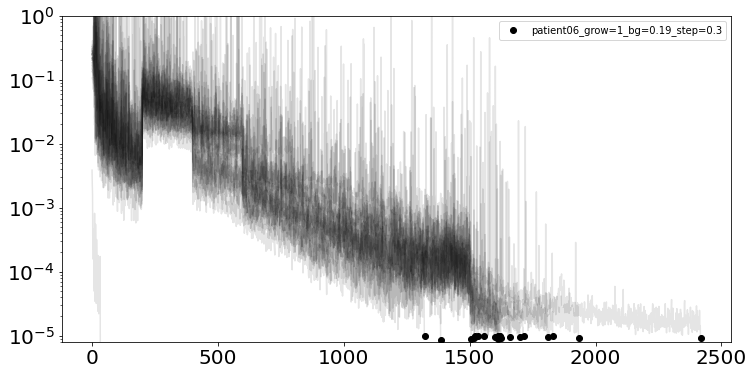

In [ ]:
len_max = 0
for i in losses_all:
  len_max = len(i) if len(i) > len_max else len_max
plt.figure(figsize=(12,6))
for idx, i in enumerate(losses_all):
  plt.semilogy(i, c='k', alpha=.1)
  if idx == 0:
    plt.scatter(len(i), i[-1], c='k', label=name_synthesis)
  else:
    plt.scatter(len(i), i[-1], c='k')
plt.legend(loc = 'upper right')
plt.ylim([8e-6,1e0])

In [ ]:
np.shape(slices_viewer3D), np.shape(im_blend2)
slices_viewer3D = np.asarray(slices_viewer3D)

(9e-06, 1.0)

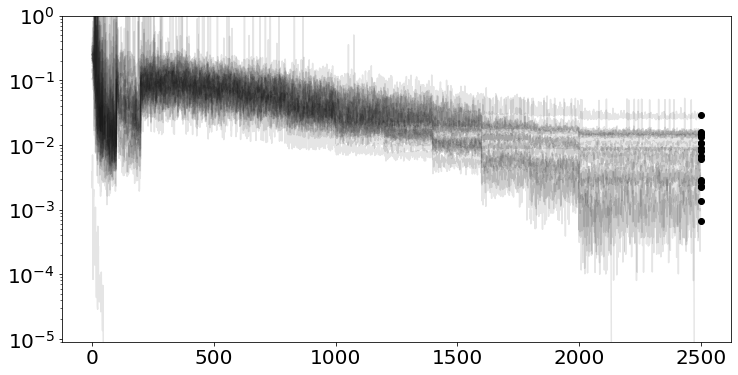

In [ ]:
len_max = 0
for i in losses_all:
  len_max = len(i) if len(i) > len_max else len_max
plt.figure(figsize=(12,6))
for i in losses_all:
  plt.semilogy(i, c='k', alpha=.1)
  plt.scatter(len(i), i[-1], c='k')
plt.ylim([9e-5,1e0])

## individual lesions

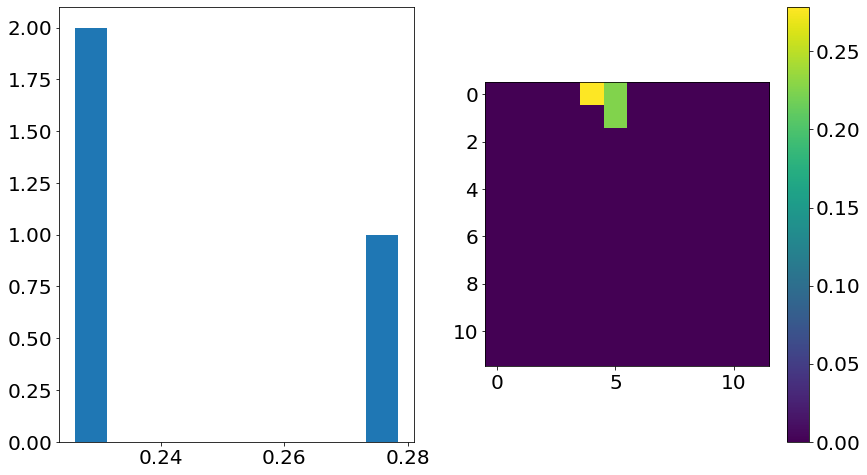

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(14,8));
ax[0].hist(syn_norm[syn_norm>0]);
im = ax[1].imshow(syn_norm);
# ax[1].axis('off');
plt.colorbar(im, ax=ax[1])

In [ ]:
distributions_all = []
PICK_A_LESION = 9
HOW_MANY_GEN = 64
for idx_lesion, (lesion, coord, mask) in enumerate(zip(lesions_all, coords_all, masks_all)):
  intensities = []
  for GEN in range(HOW_MANY_GEN):
    syn_norm = lesion[GEN]/255. # WARNING this might not be the best way to save the array (information lost)
    syn_norm = syn_norm * mask
    intensity = syn_norm[syn_norm>0]
    intensities.append(intensity)
  distributions_all.append(intensities)

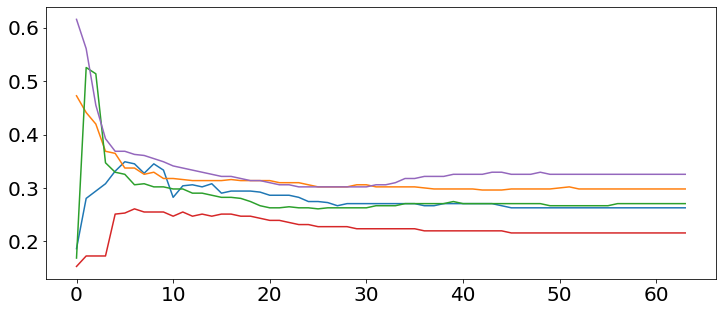

In [ ]:
plt.figure(figsize=(12,5))
for distributions in distributions_all[:5]:
  medians = [np.median(i) for i in distributions]
  plt.plot(medians)

  out=out, **kwargs)

  ret = ret.dtype.type(ret / rcount)



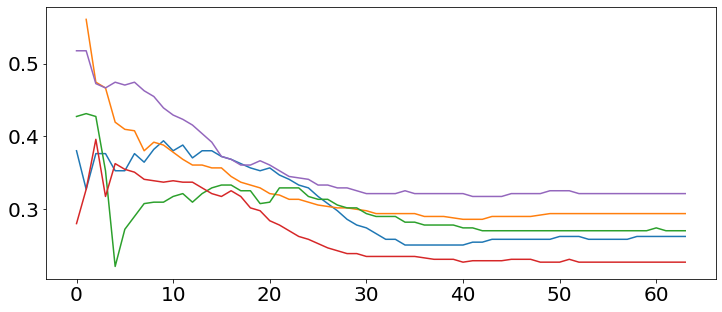

In [ ]:
plt.figure(figsize=(12,5))
for distributions in distributions_all[:5]:
  medians = [np.median(i) for i in distributions]
  plt.plot(medians)

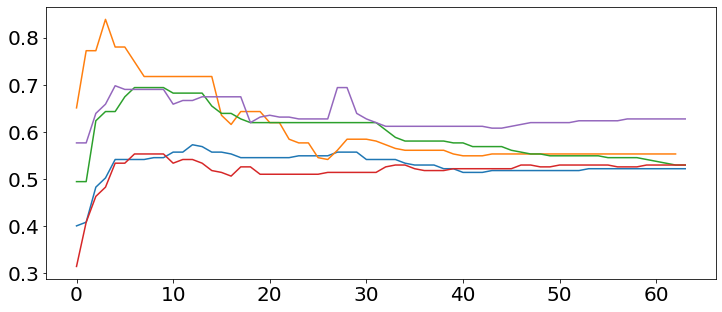

In [ ]:
plt.figure(figsize=(12,5))
for distributions in distributions_all[:5]:
  maxs = []
  for i in distributions:
    try:
      a = np.max(i)
      maxs.append(a)
    except ValueError: 'value error'
  plt.plot(maxs)

In [ ]:
PICK_A_LESION = 11
HOW_MANY_GEN = 64
# get max_intensity
max_intensity = 0
for GEN in range(HOW_MANY_GEN):
  for idx_lesion, (lesion, coord, mask) in enumerate(zip(lesions_all, coords_all, masks_all)):
    if idx_lesion != PICK_A_LESION:continue
    syn_norm = lesion[GEN]/255.
    max_intensity = np.max(syn_norm) if np.max(syn_norm) > max_intensity else max_intensity
# figure
blur_lesion = False
intensity_medians = []
Path('images').mkdir(parents=True, exist_ok=True) 
file_path = "images/image.png"
images = []
syn_norms = []
for GEN in range(HOW_MANY_GEN):
  for idx_lesion, (lesion, coord, mask) in enumerate(zip(lesions_all, coords_all, masks_all)):
    if idx_lesion != PICK_A_LESION:continue
    syn_norm = lesion[GEN]/255. # WARNING this might not be the best way to save the array (information lost)
    syn_norm = syn_norm * mask
    syn_norms.append(syn_norm)
    intensity = syn_norm[syn_norm>0]
    if blur_lesion:
      syn_norm = blur_masked_image(syn_norm, kernel_blur = (2,2))
    intensity_medians.append(np.median(intensity))
    fig,ax = plt.subplots(1,2,figsize=(14,8));
    ax[0].hist(syn_norm[syn_norm>0]);
    ax[0].set_xlim([0,1])
    ax[0].set_ylim([0,100])
    im = ax[1].imshow(syn_norm,vmin=0, vmax=max_intensity);
    ax[1].axis('off');
    plt.colorbar(im, ax=ax[1])
    fig.savefig(file_path)
    images.append(imageio.imread(file_path))
    plt.clf();
    # syn_int = (syn_norm*255).astype('uint8')
    # images.append(imageio.core.util.Array(syn_int))

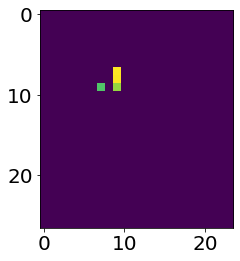

In [ ]:
np.shape(syn_norms)
idx = 0
fig,ax = plt.subplots(1,2,figsize=(14,8));
ax[0].imshow(syn_norms[idx])
ax[0].imshow(syn_norms[idx])

In [ ]:
import cv2

In [ ]:
def blur_masked_image(image, kernel_blur = (3,3)):
  '''https://answers.opencv.org/question/3031/smoothing-with-a-mask/'''
  mask_for_blur = image >0
  image[mask_for_blur == 0] = 0
  blurred_image = cv2.blur(image,kernel_blur)
  blurred_mask = cv2.blur(mask_for_blur.astype(float),kernel_blur)
  result = blurred_image / blurred_mask
  result = np.nan_to_num(result*mask_for_blur, nan=0)
  return result

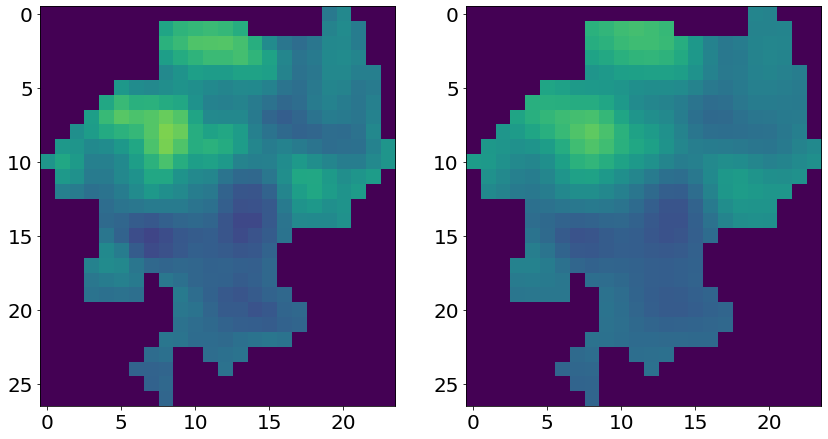

In [ ]:
image = syn_norm.copy()
kernel_blur = (3,3)
mask_for_blur = syn_norm >0
image[mask_for_blur == 0] = 0
blurred_image = cv2.blur(image,kernel_blur)
blurred_mask = cv2.blur(mask_for_blur.astype(float),kernel_blur)
result = blurred_image / blurred_mask
result = np.nan_to_num(result*mask_for_blur, nan=0)
fig,ax = plt.subplots(1,2,figsize=(14,8));
ax[0].imshow(syn_norm, vmin=0, vmax=.7)
ax[1].imshow(result, vmin=0, vmax=.7)

(<matplotlib.image.AxesImage at 0x7f32181ba090>, array([[nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]]))

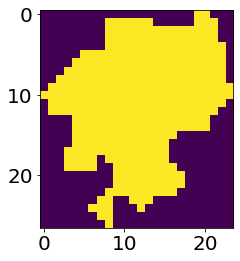

In [ ]:
plt.imshow(mask_for_blur)

In [ ]:
imageio.mimsave(f"images/one_lesion_{PICK_A_LESION}.gif", images, fps=4) #Creates gif out of list of images
mvp.ipython_display(f"images/one_lesion_{PICK_A_LESION}.gif")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
imageio.mimsave(f"images/one_lesion_{PICK_A_LESION}.gif", images, fps=4) #Creates gif out of list of images
mvp.ipython_display(f"images/one_lesion_{PICK_A_LESION}.gif")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
imageio.mimsave(f"images/one_lesion_{PICK_A_LESION}.gif", images, fps=4) #Creates gif out of list of images
mvp.ipython_display(f"images/one_lesion_{PICK_A_LESION}.gif")

Output hidden; open in https://colab.research.google.com to view.

## extra

In [ ]:
len(lesion)

256

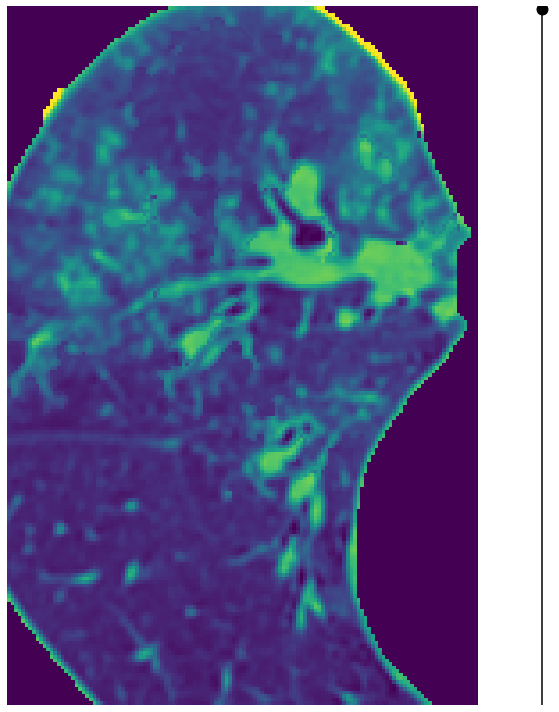

In [ ]:
# add the synthesized lesions onto the texture inpainted image
# images=[]
Path('images').mkdir(parents=True, exist_ok=True) 
file_path = "images/image.png"
im_blend2 = copy(im_blend_inpain)
slices_viewer3D = []
GEN = len(lesion)-1
for (lesion, coord, mask) in zip(lesions_all, coords_all, masks_all):
  syn_norm = lesion[GEN]/255. # WARNING this might not be the best way to save the array (information lost)
  syn_norm = syn_norm * mask
  # add background texture with absolute coordinates
  new_coords_mask = np.where(mask==1)[0]+coord[0], np.where(mask==1)[1]+coord[2]
  # add cea syn with absolute coords
  new_coords = np.where(syn_norm>0)[0]+coord[0], np.where(syn_norm>0)[1]+coord[2]
  im_blend2[new_coords] = syn_norm[syn_norm>0] 
  # im_blend[coord[0]:coord[1], coord[2]:coord[3]] = syn_norm
if GEN%2==0: #save every other synthesis for slices_viewer
  slices_viewer3D.append(im_blend2)

fig, ax = plt.subplots(1,2, gridspec_kw={'width_ratios': [30, 1]}, figsize=(9,10));
ax[0].imshow(im_blend2[y_min: y_max, x_min: x_max], cmap='viridis', vmin=0, vmax=V_MAX);
ax[1].vlines(x=0, ymin=0, ymax=len(lesion), color='k');
ax[1].scatter(0,GEN, c='k', s=120);
ax[1].set_ylim([0,len(lesion)]);
for axx in ax.ravel(): axx.axis('off');
fig.tight_layout();
# plt.savefig(file_path); #Saves each figure as an image
# images.append(imageio.imread(file_path)); #Adds images to list
# plt.clf();
# plt.close();

## continue

In [ ]:
len(lesions_all[0])

256

## TODO
- increase the iterations of the inner loop progresively   
- Start with good training, then when it's properly trained switch to growig the mask ocasionally   
- put a mask on the loss to focus on the are grown (and maybe a little more using dilations?)      
- use distance transform to give a weighted mask   
- CLAMP THE NEW ALIVE PIXELS TO THE VALUES OF THE INPAINTED VERSION   